In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

/tmp/ipykernel_758172/1061915113.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True
plt.rcParams['axes.linewidth']=1.5

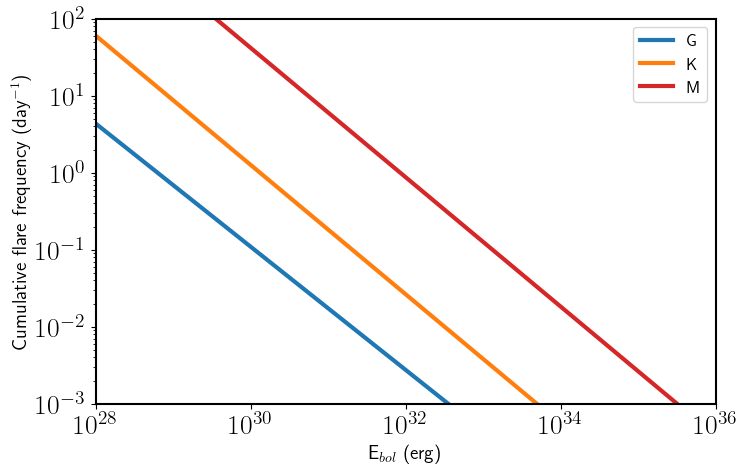

In [3]:
# M & K dwarf FFD

# Howard+2019 for active M2 and K5 dwarfs (assumed representative for all M's and K's)
# log nu = alpha * log E_bol + beta
# nu is the cumulative flare frequency (per day)

e_bol = np.logspace(27,40,1000) # bolometric flare energy array you can change this range 
#lowest flare energy TESS will be sensitive to, I think might be 10** 26 erg?? (need to double check that in literature)
                                       
        
beta_M = 26.82
alpha_M = -0.84

#beta_K = 44.55
#alpha_K = -1.34 # This is so steep at low flare energies it causes memory problems!
alpha_K = -0.84 # so I made the K dwarf FFD intermediate to the M and G dwarf FFDs
beta_K = 25.3

nu_M = 10**beta_M * (e_bol)**alpha_M
nu_K = 10**beta_K * (e_bol)**alpha_K





# G dwarf FFD

# Shibayama+ 2013 Figure 9 - a fit to all G dwarfs (Sun included)
# The form of this FFD is 
# log dN/dE = alpha * log E_bol + beta, where dN/dE has units erg^-1 star^-1 yr^-1, 
# so I'll have to multiply by the energy array and divide by 365 days/yr to convert to day^-1
beta_G = 25.6
alpha_G = -1.8

nu_G = (10**beta_G * (e_bol)**alpha_G) * e_bol / 365.

#plt.figure()
plt.plot(e_bol, nu_G, label='G',color='C0',lw=3)
plt.plot(e_bol,nu_K,label='K',color='C1',lw=3)
plt.plot(e_bol,nu_M,label='M',color='C3',lw=3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('E$_{bol}$ (erg)',fontsize=14)
plt.ylabel('Cumulative flare frequency (day$^{-1}$)',fontsize=14)



#accounting for age
#plt.plot(e_bol,nu_M/10,label='M',color='C5',ls='--')

plt.xlim(10e27,1e36)
plt.ylim(10e-4,1e2)
plt.legend(fontsize=12)
#plt.savefig('ffds.pdf',bbox_inches='tight')

In [4]:
energy = np.logspace(29,40,1000) # bolometric flare energy array
def nu_M(energy):
    beta = 26.82
    alpha = -0.84
    nu_M = 10**beta * (energy)**alpha
    return nu_M

def nu_K(energy):
    alpha_K = -0.84
    beta_K = 25.3
    nu_K = 10**beta_K * (energy)**alpha_K
    return nu_K

def nu_G(energy):
    beta_G = 25.6
    alpha_G = -1.8
    nu_G = (10**beta_G * (energy)**alpha_G) * e_bol / 365.
    return nu_G

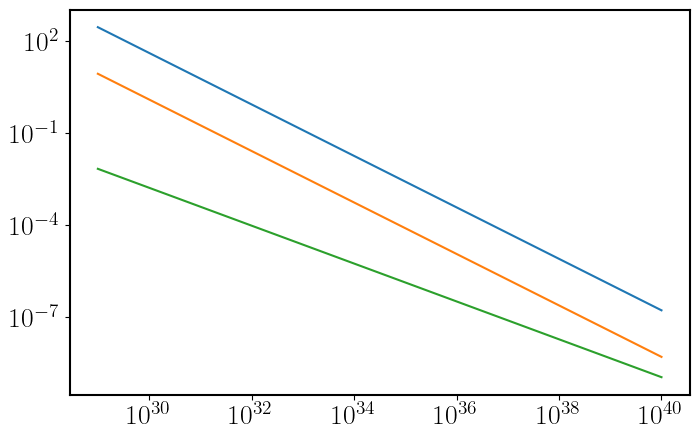

In [5]:
plt.plot((energy),nu_M(energy))
plt.plot((energy),nu_K(energy))
plt.plot((energy),nu_G(energy))
plt.yscale('log')
plt.xscale('log')

### Importing in super flare properties from Althukair et al 2023 https://arxiv.org/abs/2212.10224

In [6]:
superflares = {'G': pd.read_csv('../data/G-type-superflares.csv'),
               'K': pd.read_csv('../data/K-type-superflares.csv'),
               'M': pd.read_csv('../data/M-type-superflares.csv')}

In [7]:
line_fits = {}
scatter = {}
for stellar_class in ['G', 'K', 'M']:
    energies = superflares[stellar_class]['energy'].values
    amps = superflares[stellar_class]['flare_amp'].values
    sort = np.argsort(energies)
    energies = energies[sort]
    amps = amps[sort]
    line_fits[stellar_class] = np.poly1d(np.polyfit(np.log10(energies), np.log10(amps), 1))
    scatter[stellar_class] = np.std(np.log10(amps) / line_fits[stellar_class](np.log10(energies)))

In [8]:
lupita_line_fits = {}
lupita_scatter = {}
for stellar_class in ['G', 'K', 'M']:
    energies = superflares[stellar_class]['energy'].values
    amps = superflares[stellar_class]['flare_amp'].values
    energies = np.sort(energies)
    amps = np.sort(amps)
    lupita_line_fits[stellar_class] = np.poly1d(np.polyfit(np.log10(energies), np.log10(amps), 1))
    lupita_scatter[stellar_class] = np.std(np.log10(amps) / lupita_line_fits[stellar_class](np.log10(energies)))

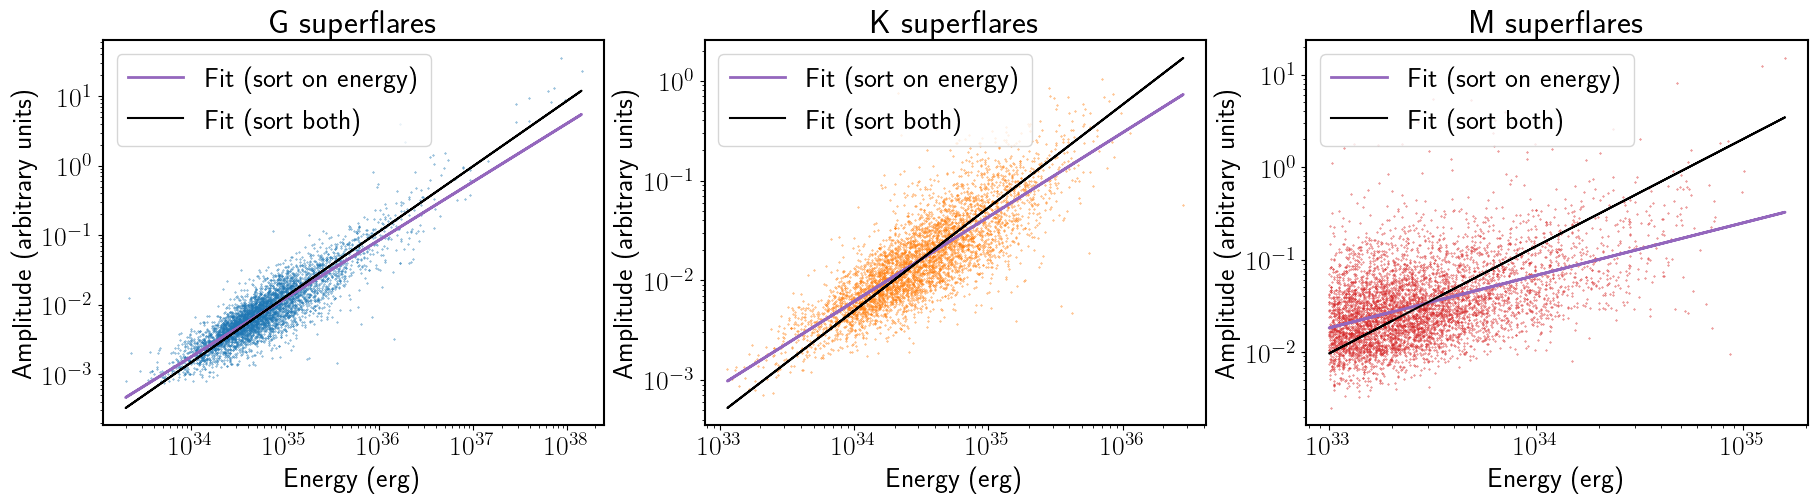

In [9]:
fig, axes = plt.subplots(1,3,figsize=(22, 5))

for ax, stellar_class, col in zip(axes, ['G', 'K', 'M'], ["C0", "C1", "C3"]):
    ax.scatter(superflares[stellar_class]['energy'], superflares[stellar_class]['flare_amp'], color=col, s=.1)
    ax.set(xscale='log', yscale='log', xlabel='Energy (erg)', ylabel='Amplitude (arbitrary units)',
           title=stellar_class + ' superflares')
    ax.plot(superflares[stellar_class]['energy'],
            10**(line_fits[stellar_class](np.log10(superflares[stellar_class]['energy']))),
            label='Fit (sort on energy)', color='tab:purple', zorder=10, lw=2)
    ax.plot(superflares[stellar_class]['energy'],
            10**(lupita_line_fits[stellar_class](np.log10(superflares[stellar_class]['energy']))),
            label='Fit (sort both)', color='black', zorder=11)
    ax.legend()
plt.show()

The functions for the log fits are below (p,pk,pm for GKM stars respectively)

In [10]:
line_fits

{'G': poly1d([  0.84035814, -31.32253076]),
 'K': poly1d([  0.84691786, -31.00765701]),
 'M': poly1d([  0.56818383, -20.48800255])}

In [12]:
line_fits["M"](27)

-5.147039038028604

In [14]:
scatter["M"]

0.27823866674159486

### Extrapolating to lower energies
example for how I did it for the M stars (will need to do something similar for G&K)

Note this code might not run out of the box since I quickly copied it over from another notebook, but hopefully it helps illustrate the approach to take!

In [18]:
from scipy.optimize import curve_fit

In [19]:
# Fit data to linear functions
def linear_fit(x, m, b):
    return m * x + b

##### Fit AMP data with scipy curve_fit function with results from superflares data
popt_amp, covariance_amp = curve_fit(linear_fit, mstars_e, np.log10(mstars_amps))



##### Fit FWHM data 
#popt_fwhm, covariance_fwhm = curve_fit(linear_fit, results.logE, np.log10(results.fwhm))



# Generate extrapolated Energy values
extrapolated_energy    = np.logspace(25, 30, num=len(mstars_e))
extrapolated_logE      = np.log10(extrapolated_energy)



# Extrapolate AMP
extrapolated_amp       = linear_fit(extrapolated_logE, popt_amp[0], popt_amp[1])
log_scatter_values_amp = np.random.uniform(-0.5, 0.5, size=len(extrapolated_logE))
extrapolated_amp      += log_scatter_values_amp  # Add scatter to extrapolated AMP data


##### Fit AMP data with scipy curve_fit function for extrapolated data
popt_extrapolated_amp, covariance_extrapolated_amp   = curve_fit(linear_fit, extrapolated_logE, extrapolated_amp)


# comparing slopes for results data and extrapolated data
print("Slope of results.amp      : {:.4f}".format(popt_amp[0]))
print("Slope of extrapolated_amp : {:.4f}".format(popt_extrapolated_amp[0]))
print(" ")

Slope of results.amp      : 0.0000
Slope of extrapolated_amp : -0.0001
 


### All of the code we walked through above in function form

In [ ]:
def get_amps(log_energy,teff=5999.,scatter=0.2):

    # log_energy is the bolometric flare energy

    threshold_mask = log_energy < 32.5

    #M 
    if teff < 3900.:
        log_amp = 1.16 * log_energy + (-40.28)
        scatter = 2.4 
        log_amp += np.random.randn(len(log_amp)) * scatter
        amp = 10**log_amp
        #the threshold mask applies to lower energy flares (e.g. extrapolation fit values)
        amp[threshold_mask] = 10 ** (0.48398594 * log_energy[threshold_mask] + (-16.98696142) + scatter*np.random.randn(sum(threshold_mask)))

    #K
    elif teff < 5300.:
        log_amp = 1.034 *log_energy +  (-37.47) 
        scatter = 0.039 
        log_amp += np.random.randn(len(log_amp)) * scatter
        amp = 10**log_amp
        
    #G
    elif teff < 6000.:
        log_amp = 0.9418 *log_energy + (-34.85)
        scatter = 0.2
        log_amp += np.random.randn(len(log_amp)) * scatter
        amp = 10**log_amp
    else:
        print('Error: Try new Teff')

    return amp

In [ ]:
def get_flare_fwhm_from_energy_and_amplitude(log_roman_E, roman_amps, stellar_L_Roman): 
    fwhm = (10**log_roman_E / 2.04087) / (roman_amps * 10**stellar_L_Roman)
    return fwhm*60. # converting units


### Bandpass Energy Calculations

The amplitudes are in the Kepler bandpass so you will need to convert to TESS! Below is what I did to convert from Kepler to Roman

In [15]:
roman_bp = pd.read_excel('Roman_effarea_20201130.xlsx',skiprows=1)
kepler_bp = pd.read_table('Kepler.csv',delimiter=' ',names=['Wavelength', 'transmission'])

In [16]:
from astropy.modeling.models import BlackBody
from astropy import units as u

In [17]:
ang_units = u.erg / (u.cm ** 2 * u.s * u.AA * u.sr)
ang_units

Unit("erg / (Angstrom cm2 s sr)")

Bolometric flux (from normalized curve, ignore units) = 4405.037266699876 Angstrom


Text(0, 0.5, 'Flux Density')

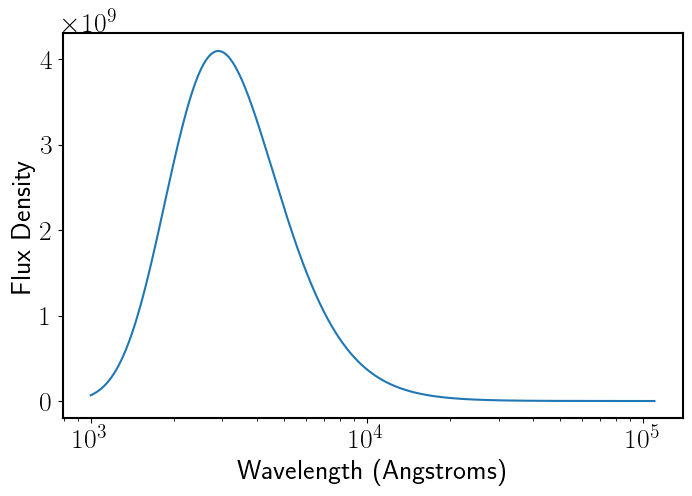

In [18]:
temperature = 10000 *u.K

bb_func = BlackBody(temperature=temperature,scale=100*ang_units)
wav = np.arange(1000, 110000) * u.AA
flux = bb_func(wav)
flux_bolo = np.trapz(flux/np.max(flux), wav)
print('Bolometric flux (from normalized curve, ignore units) = ' + str(flux_bolo))
plt.plot(wav,flux)
plt.xscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux Density')

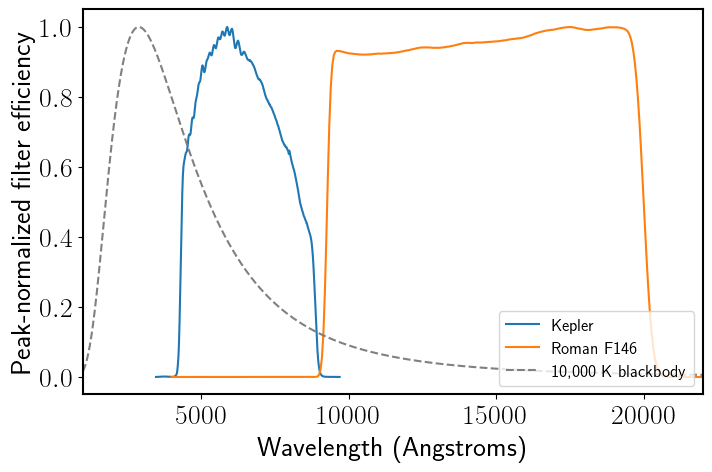

In [19]:
plt.plot(kepler_bp['Wavelength'], kepler_bp['transmission']/np.max(kepler_bp['transmission']),label='Kepler')
#plt.plot(tess['Wavelength'], tess['transmission']/np.max(tess['transmission']),label='TESS')
plt.plot(roman_bp['Wave']*1e4,roman_bp[' F146']/np.max(roman_bp[' F146']),label='Roman F146')
plt.plot(wav,flux/np.max(flux),color='grey', linestyle='--',label='10,000 K blackbody')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Peak-normalized filter efficiency')
plt.xlim([1000,22000])
plt.legend(fontsize=12,loc='lower right')

Text(0.5, 1.0, 'Kepler = 0.30651187627311094')

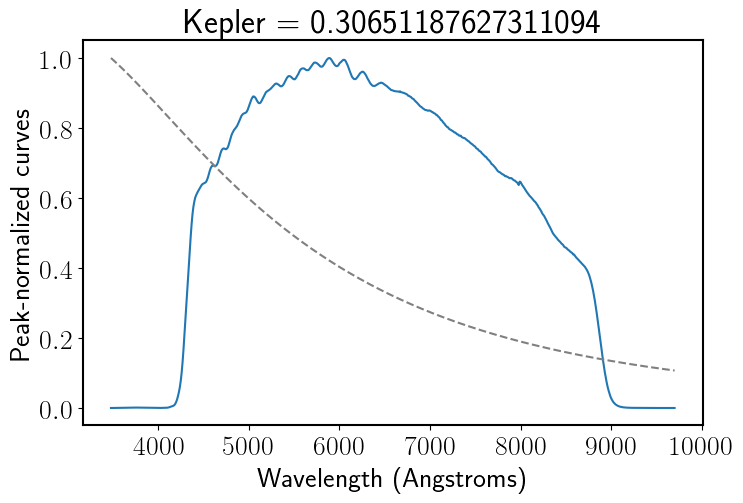

In [20]:
## Kepler bandpass
flux_kepler = bb_func(np.array(kepler_bp['Wavelength'])*u.AA)
#plt.figure()
plt.plot(kepler_bp['Wavelength'], kepler_bp['transmission']/np.max(kepler_bp['transmission']),color='C0')
plt.plot(kepler_bp['Wavelength'], flux_kepler/np.max(flux_kepler),color='grey', linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Peak-normalized curves')
#plt.xlim([1000,22000])
plt.title('Kepler = ' + str( np.trapz(flux_kepler/np.max(flux_kepler) * kepler_bp['transmission']/np.max(kepler_bp['transmission']), kepler_bp['Wavelength']) / flux_bolo.value) )


In [21]:
kep_bbe = np.trapz((flux_kepler/np.max(flux_kepler))* (kepler_bp['transmission']/np.max(kepler_bp['transmission'])), kepler_bp['Wavelength']) / (flux_bolo.value)
print(kep_bbe)

0.306511876273111


Text(0.5, 1.0, 'Roman F146 = 0.10406773105058177')

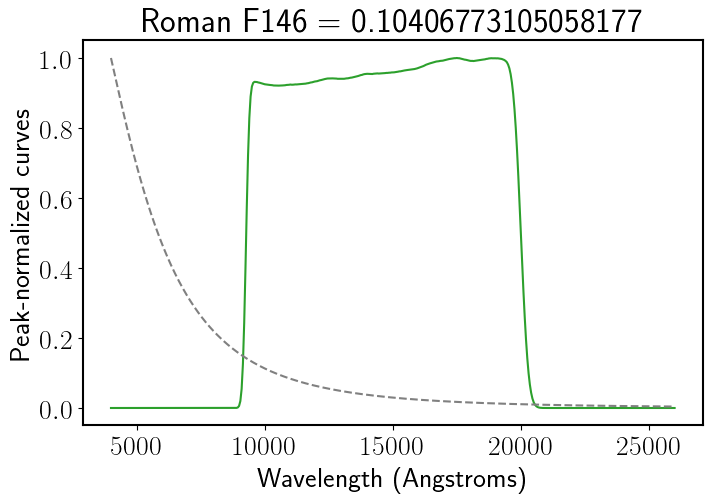

In [22]:
## Roman F146 bandpass
flux_roman = bb_func(np.array(roman_bp['Wave']*1e4)*u.AA)
plt.figure()
plt.plot(roman_bp['Wave']*1e4, roman_bp[' F146']/np.max(roman_bp[' F146']),color='C2')
plt.plot(roman_bp['Wave']*1e4, flux_roman/np.max(flux_roman),color='grey', linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Peak-normalized curves')
plt.title('Roman F146 = ' + str( np.trapz(flux_roman/np.max(flux_roman) * roman_bp[' F146']/np.max(roman_bp[' F146']), roman_bp['Wave']*1e4) / flux_bolo.value) )


In [23]:
roman_bbe = np.trapz((flux_roman/np.max(flux_roman))* (roman_bp[' F146']/np.max(roman_bp[' F146'])), roman_bp['Wave']*1e4) / (flux_bolo.value)
print(roman_bbe)

0.10406773105058176


In [24]:
ratio = roman_bbe/kep_bbe
print(ratio)

0.3395226714081851


In [25]:
0.3395226714081851 * (10**34)

3.3952267140818507e+33

In [26]:
def star_bandpass_conversion(temperature):
    #for a given star temp what's the star luminosity change from kepler to roman
        
    roman_bp = pd.read_excel('Roman_effarea_20201130.xlsx',skiprows=1)
    kepler_bp = pd.read_table('Kepler.csv',delimiter=' ',names=['Wavelength', 'transmission'])
    ang_units = u.erg / (u.cm ** 2 * u.s * u.AA * u.sr)
    bbtemp= temperature*u.K
    bb_func = BlackBody(temperature=bbtemp,scale=100*ang_units)
    
    wav = np.arange(1000, 110000) * u.AA
    flux = bb_func(wav)
    flux_bolo = np.trapz(flux/np.max(flux), wav)
    
    flux_kepler = bb_func(np.array(kepler_bp['Wavelength'])*u.AA)
    flux_roman =  bb_func(np.array(roman_bp['Wave']*1e4)*u.AA)
    
    kep_bbe = np.trapz((flux_kepler)* (kepler_bp['transmission']/np.max(kepler_bp['transmission'])), kepler_bp['Wavelength']) / (flux_bolo.value)
    roman_bbe = np.trapz((flux_roman)* (roman_bp[' F146']/np.max(roman_bp[' F146'])), roman_bp['Wave']*1e4) / (flux_bolo.value)
    
    roman_star_es = roman_bbe/kep_bbe
    
    return roman_star_es

In [27]:
def energy_conversion(ffd_energy,amp,teff=3500): 
    #conversion from bolometric E to Roman E
    roman_energies = 0.3395226714081851 * ffd_energy
    roman_star_es = star_bandpass_conversion(teff)
    roman_amps = amp * 0.3395226714081851 * roman_star_es
    return roman_energies, roman_amps

In [28]:
def get_flare_fwhm_from_energy_and_amplitude(roman_energies, roman_amps, stellar_L_Roman):
    fwhm = 10**roman_energies / 2.04087 / (roman_amps * 10**stellar_L_Roman) 
    return fwhm # seconds